In [ ]:
from google.colab import files
uplaoded = files.upload()

Saving US_Accidents_Stratified_Sample.csv to US_Accidents_Stratified_Sample.csv


In [ ]:
#import libraries, add additional libraries as needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson
from sklearn.feature_selection import f_classif, SelectKBest

In [ ]:
## Data Cleaning - It involves identifying missing values, detecting outliers, handling inconsistencies if any

acc_data = pd.read_csv('US_Accidents_Stratified_Sample.csv')

acc_data_info = acc_data.info()
acc_data_head = acc_data.head()

acc_data_info, acc_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77284 entries, 0 to 77283
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     77284 non-null  object 
 1   Source                 77284 non-null  object 
 2   Severity               77284 non-null  int64  
 3   Start_Time             77284 non-null  object 
 4   End_Time               77284 non-null  object 
 5   Start_Lat              77284 non-null  float64
 6   Start_Lng              77284 non-null  float64
 7   End_Lat                43356 non-null  float64
 8   End_Lng                43356 non-null  float64
 9   Distance(mi)           77284 non-null  float64
 10  Description            77284 non-null  object 
 11  Street                 77177 non-null  object 
 12  City                   77282 non-null  object 
 13  County                 77284 non-null  object 
 14  State                  77284 non-null  object 
 15  Zi

(None,
           ID   Source  Severity           Start_Time             End_Time  \
 0  A-3726992  Source1         2  2022-05-02 07:33:26  2022-05-02 08:48:28   
 1  A-1897039  Source2         2  2019-09-06 07:16:55  2019-09-06 08:16:43   
 2  A-5710019  Source1         2  2021-07-27 11:28:29  2021-07-27 13:26:15   
 3  A-7271253  Source1         2  2020-02-21 14:07:00  2020-02-21 15:20:21   
 4  A-6807168  Source1         2  2020-11-14 05:32:00  2020-11-14 08:09:14   
 
    Start_Lat   Start_Lng    End_Lat     End_Lng  Distance(mi)  ... Roundabout  \
 0  37.403823  -77.424978  37.431753  -77.431268         1.960  ...      False   
 1  33.572609  -81.774269        NaN         NaN         0.000  ...      False   
 2  31.759168 -106.355764  31.762187 -106.360597         0.352  ...      False   
 3  43.947930  -92.042720  43.947930  -92.042720         0.000  ...      False   
 4  38.363234 -122.721242  38.363237 -122.725248         0.217  ...      False   
 
   Station   Stop Traffic_Cal

#Data Cleaning

In [ ]:
# Converting 'Start_Time' and 'End_Time' to datetime objects
acc_data['Start_Time'] = pd.to_datetime(acc_data['Start_Time'])
acc_data['End_Time'] = pd.to_datetime(acc_data['End_Time'])

# Handling Missing values - Imputing missing numerical data with median for coordinates and mean for other columns
num_columns = acc_data.select_dtypes(include=['float64', 'int64']).columns
loc_coordinates = ['End_Lat', 'End_Lng']  # Coordinates to be imputed with median
for column in num_columns:
    if column in loc_coordinates:
        imputer = SimpleImputer(strategy='median')
    else:
        imputer = SimpleImputer(strategy='mean')
    acc_data[column] = imputer.fit_transform(acc_data[[column]])

# Imputing missing categorical data with the most frequent value
categorical_columns = acc_data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    acc_data[column].fillna(acc_data[column].mode()[0], inplace=True)

# Handling Outliers in Distance(mi) column using the IQR method
Q1_distance = acc_data['Distance(mi)'].quantile(0.25)
Q3_distance = acc_data['Distance(mi)'].quantile(0.75)
IQR_distance = Q3_distance - Q1_distance
lower_bound_distance = Q1_distance - 1.5 * IQR_distance
upper_bound_distance = Q3_distance + 1.5 * IQR_distance
acc_data = acc_data[~((acc_data['Distance(mi)'] < lower_bound_distance) | (acc_data['Distance(mi)'] > upper_bound_distance))]

# Confirming that there are no missing values left
missing_values_final = acc_data.isnull().sum()
missing_values_final_all = all(missing_values_final == 0)

print(acc_data.shape)

print(missing_values_final_all)
acc_data.head()


(42832, 46)
True


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
1,A-1897039,Source2,2.0,2019-09-06 07:16:55,2019-09-06 08:16:43,33.572609,-81.774269,36.234020,-88.101163,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-7271253,Source1,2.0,2020-02-21 14:07:00,2020-02-21 15:20:21,43.947930,-92.042720,43.947930,-92.042720,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
6,A-2642212,Source2,2.0,2018-08-13 10:15:10,2018-08-13 10:59:53,35.263432,-80.921234,36.234020,-88.101163,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
7,A-1740961,Source2,2.0,2019-10-08 07:16:30,2019-10-08 08:15:59,30.410839,-97.709518,36.234020,-88.101163,0.000,...,False,False,False,False,True,False,Night,Day,Day,Day
10,A-6902606,Source1,2.0,2020-12-12 22:25:46,2020-12-13 01:09:35,36.043037,-86.606208,36.042491,-86.607208,0.067,...,False,False,False,False,False,False,Night,Night,Night,Night


In [ ]:
# Now that the data is cleaned, we proceed with scaling the numerical features
# We are excluding the 'Severity' column as we are taking it as the target variable

# Exclude 'Severity' for scaling
numeric_columns = acc_data.select_dtypes(include=['int64', 'float64']).columns.drop('Severity')

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the numeric columns and transform the data
acc_data[numeric_columns] = scaler.fit_transform(acc_data[numeric_columns])

acc_data[numeric_columns].head()


,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
1,0.367514,0.755848,0.476890,0.289562,0.000000,0.571160,0.528763,0.877551,0.207620,0.190137,0.000000,0.665503
3,0.795367,0.573911,0.796072,0.218407,0.000000,0.370533,0.247655,0.591837,0.237051,0.190137,0.295909,0.000000
6,0.437240,0.770962,0.476890,0.289562,0.000000,0.634483,0.447234,0.755102,0.431091,0.190137,0.184342,0.665503
7,0.237130,0.473506,0.476890,0.289562,0.000000,0.539812,0.485718,0.775510,0.220728,0.190137,0.125041,0.000000
10,0.469389,0.670235,0.468965,0.320904,0.999993,0.433229,0.334778,0.704082,0.232270,0.190137,0.232517,0.000000


In [ ]:
#Handling Skewed Data Distributions

# Identify numeric columns from the dataset except 'Severity' column as it is the target variable
numeric_columns = acc_data.select_dtypes(include=['int64', 'float64']).columns.drop('Severity')

# Calculating the skewness for each numeric column
skewness = acc_data[numeric_columns].skew().sort_values(ascending=False)

# Identifying columns with skewness outside the range -0.5 to 0.5
skewed_columns = skewness[abs(skewness) > 0.5].index.tolist()

# Applying Yeo-Johnson transformation - The Yeo-Johnson transformation can handle both positive and negative values
for col in skewed_columns:
    acc_data[col], _ = yeojohnson(acc_data[col])

#Checking the skewness after Yeo-Johnson transformation
transformed_skewness_yeojohnson = acc_data[skewed_columns].skew()

transformed_skewness_yeojohnson


Distance(mi)    1.290969
dtype: float64

#Exploratory Data Analysis (EDA)

In [ ]:
# Displaying Descriptive statistics for the dataset
descriptive_statistics = acc_data.describe(include='all', datetime_is_numeric=True)

descriptive_statistics

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,42832,42832,42832.000000,42832,42832,42832.000000,42832.000000,42832.000000,42832.000000,42832.000000,...,42832,42832,42832,42832,42832,42832,42832,42832,42832,42832
unique,42832,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,1,2,2,2,2
top,A-1897039,Source2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
freq,1,30693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42829,41482,41346,42783,33096,42832,30640,32744,34970,36637
mean,NaN,NaN,2.251424,2019-09-28 09:04:42.981602560,2019-09-28 10:50:28.024934912,0.469843,0.519349,0.476164,0.276714,0.008518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,2016-02-09 07:15:41,2016-02-09 07:45:41,0.000000,0.000000,0.000000,0.000000,-0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.000000,2018-04-17 09:39:25.500000,2018-04-17 10:42:05,0.357818,0.127549,0.476890,0.289562,-0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2.000000,2019-10-18 08:27:31.500000,2019-10-18 09:49:28,0.441357,0.642191,0.476890,0.289562,-0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,3.000000,2021-02-09 13:46:30,2021-02-09 19:00:12.750000128,0.625182,0.771798,0.476890,0.289562,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,4.000000,2023-03-31 20:16:30,2023-03-31 21:57:43,1.000000,1.000000,1.000000,1.000000,0.037224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


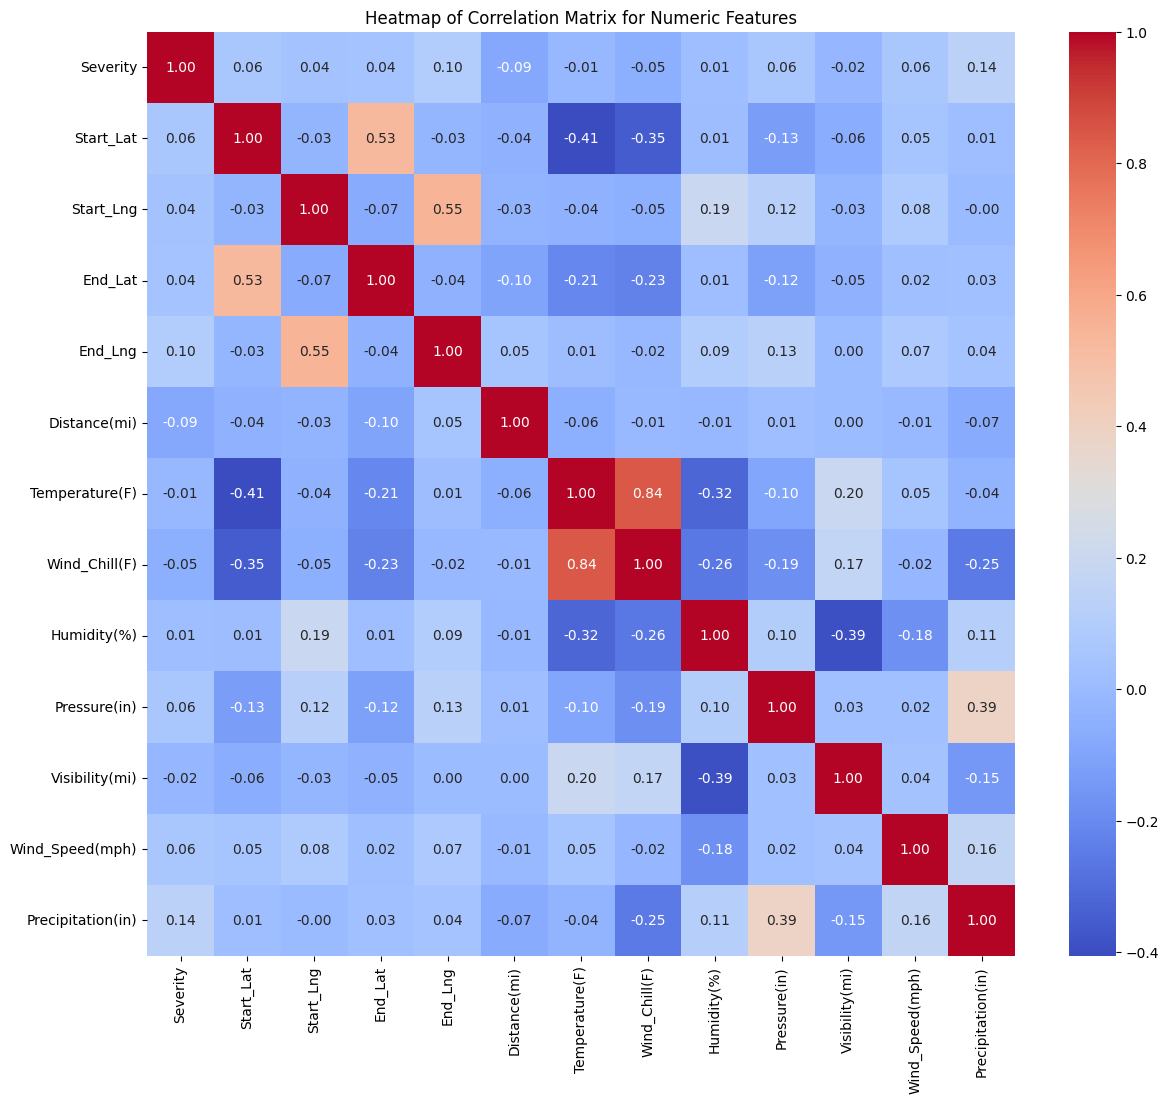

In [ ]:
# Correlation Analysis
# Calculate the correlation matrix for numerical features
numeric_data = acc_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Plotting the Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Correlation Matrix for Numeric Features')
plt.show()


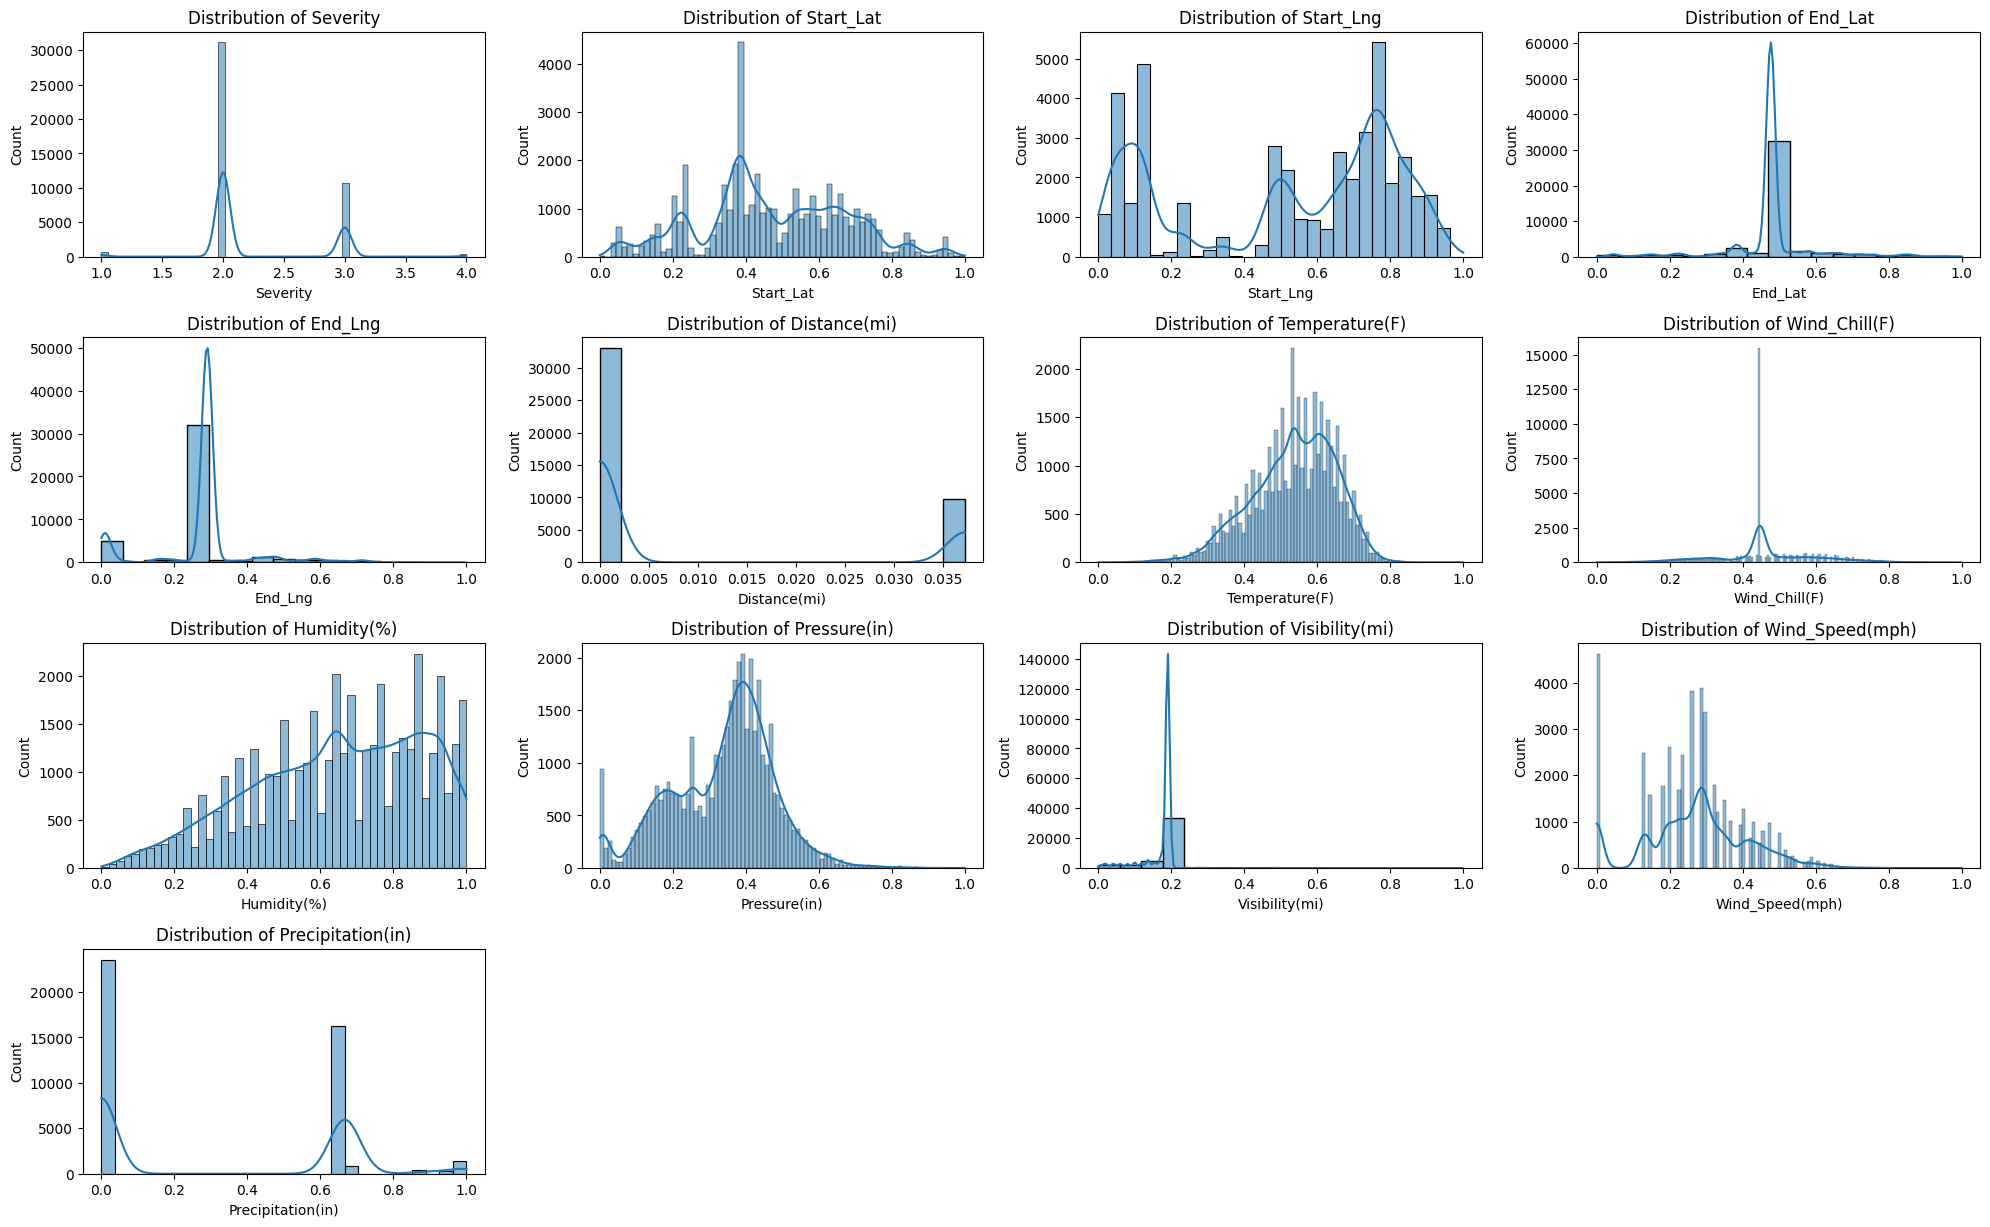

In [ ]:
# Visualization of distributions and relationships
#Plotting histograms, scatter plots, box plots to understand distributions and relationships in the data

# Histograms for all numeric features
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(numeric_data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

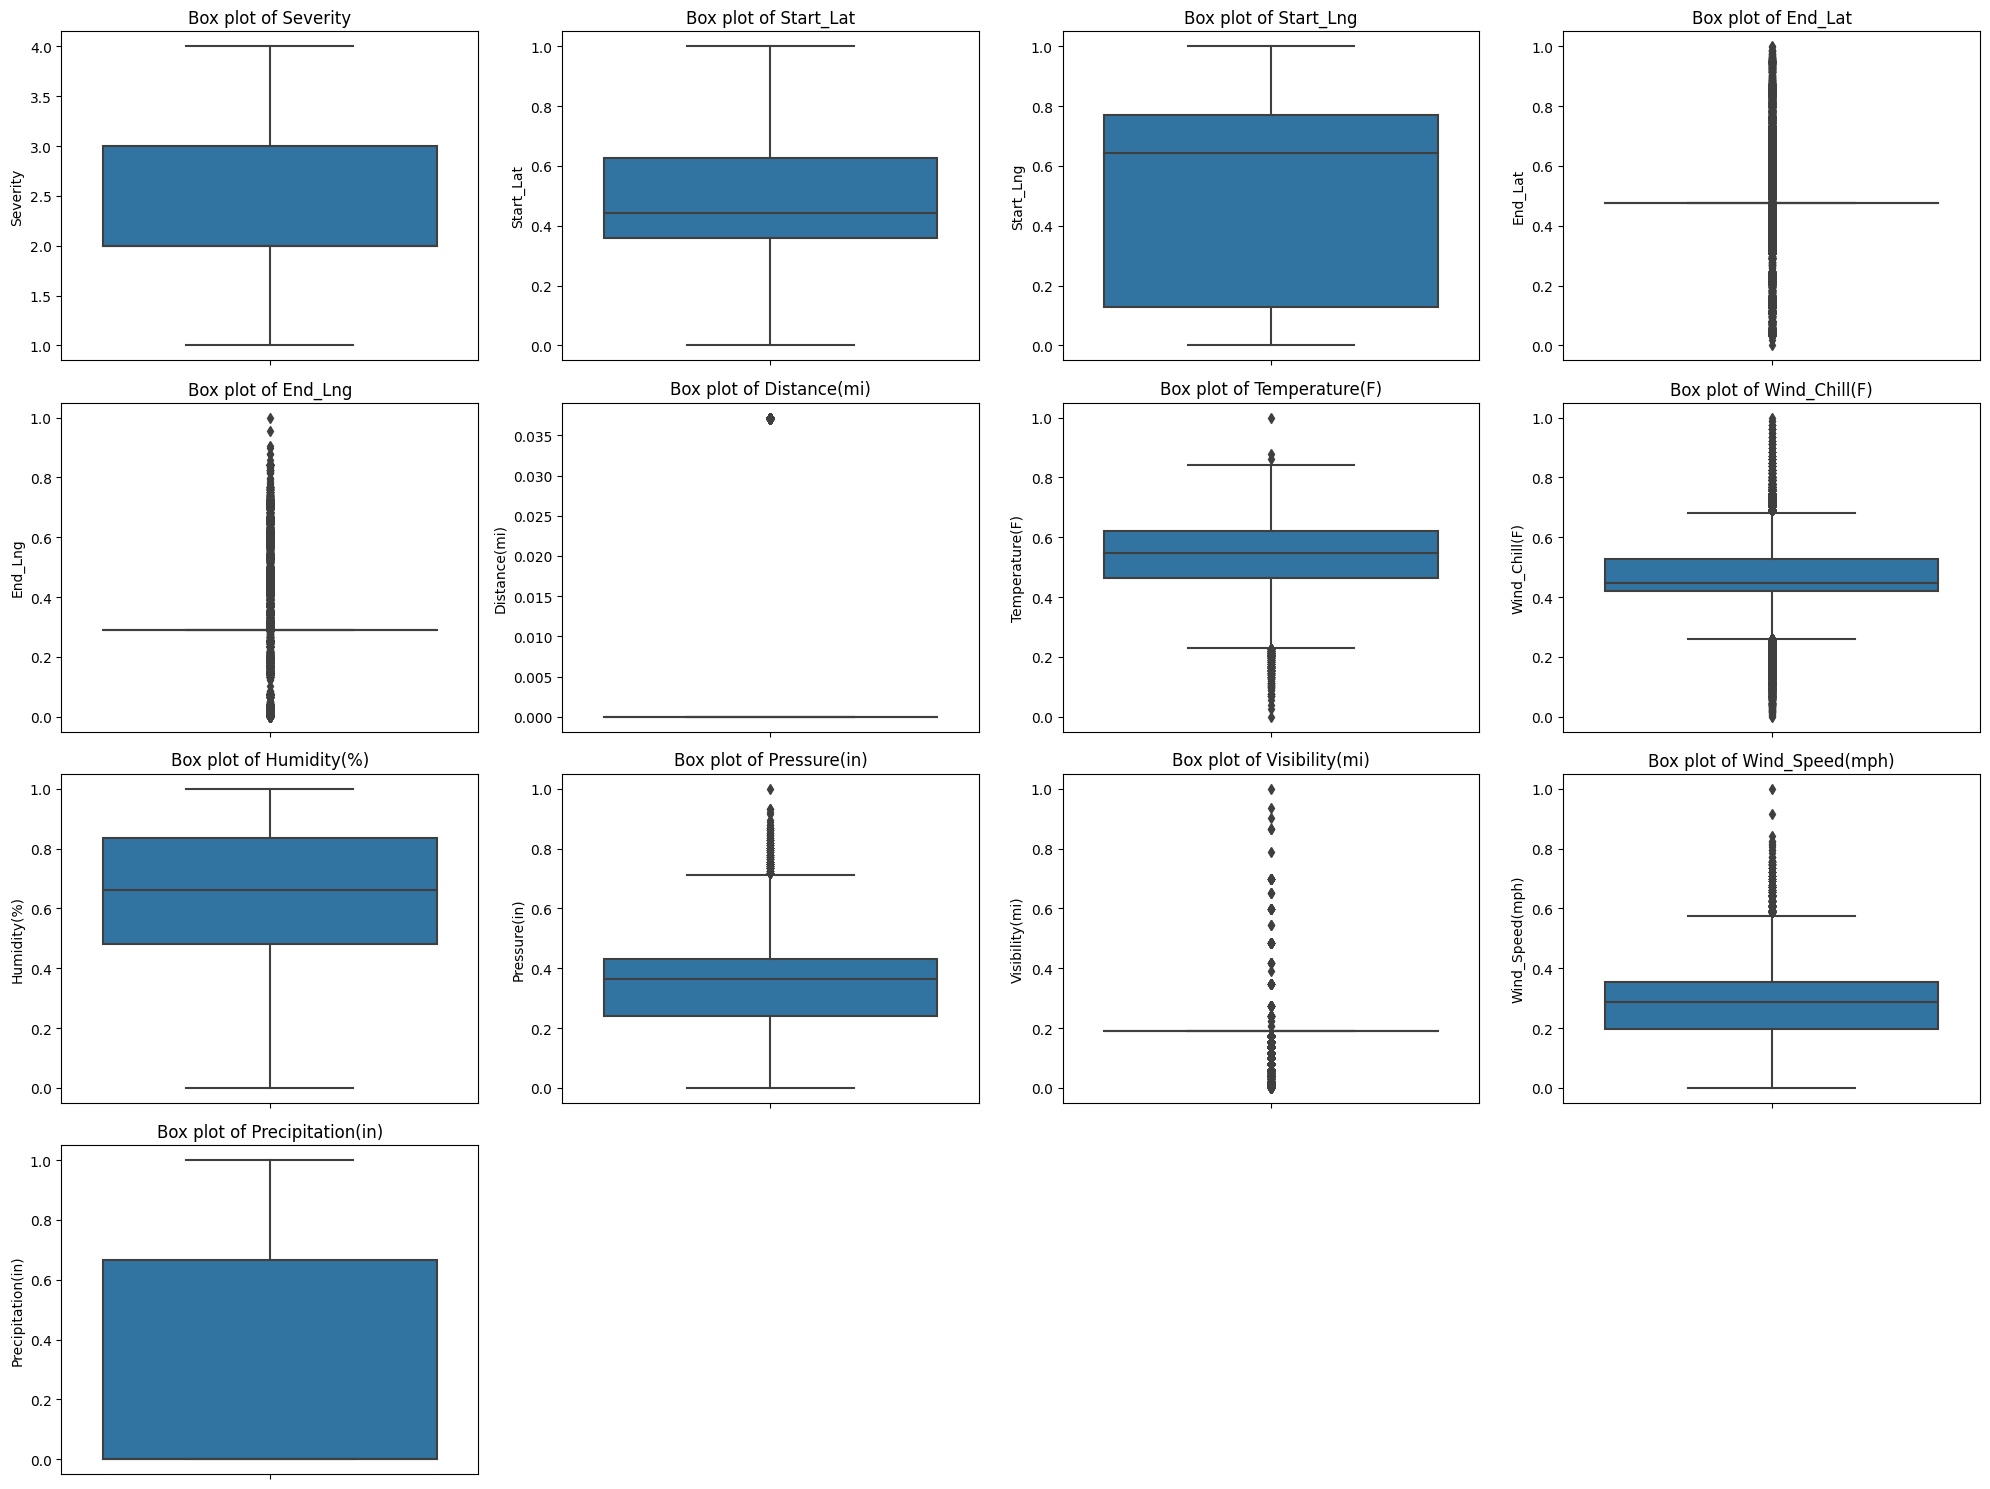

In [ ]:
# Box plots to check for outliers in numeric data
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot((len(numeric_data.columns) - 1) // 4 + 1, 4, i + 1)
    sns.boxplot(y=numeric_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

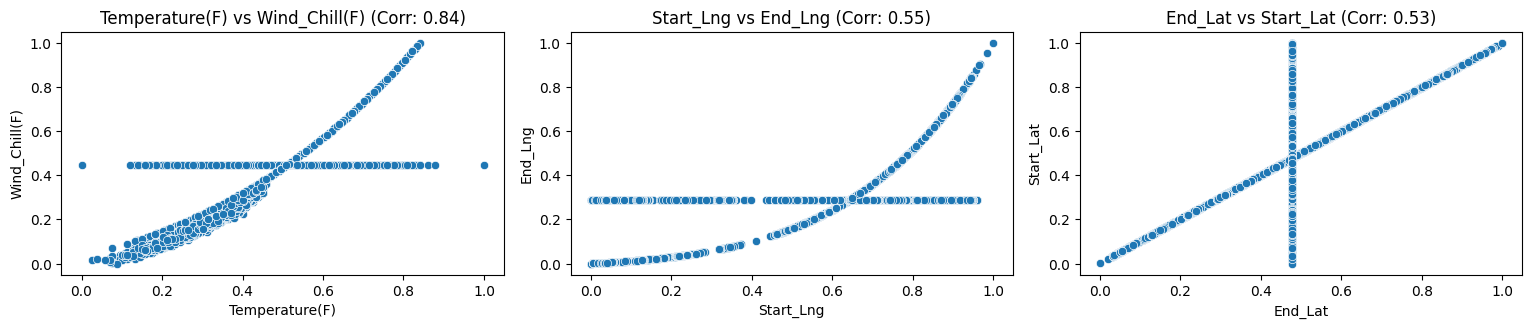

In [ ]:
# Scatter plots for pairs of features with strong correlations

# Plotting top pairs of correlated features
plt.figure(figsize=(20, 15))
corr_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
strong_pairs = corr_pairs[abs(corr_pairs) > 0.5].drop_duplicates()

for i, ((feature1, feature2), corr_value) in enumerate(strong_pairs.items()):
    if feature1 != feature2:  # Exclude self-correlation
        plt.subplot(5, 4, i + 1)
        sns.scatterplot(data=numeric_data, x=feature1, y=feature2)
        plt.title(f'{feature1} vs {feature2} (Corr: {corr_value:.2f})')
        if i >= 19:
            break
plt.tight_layout()
plt.show()


#Baseline Model

In [ ]:
#Feature Selection using ANOVA

# Preparing the feature set for feature selection, excluding non-numeric columns and datetime columns
X = acc_data.select_dtypes(include=[np.number]).drop(columns=['Severity'])
y = acc_data['Severity']

# ANOVA F-value selection
selector_f_classif = SelectKBest(score_func=f_classif, k=10)
X_new_f_classif = selector_f_classif.fit(X, y)
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F Score': X_new_f_classif.scores_,
    'P Value': X_new_f_classif.pvalues_
})
anova_results_sorted = anova_results.sort_values(by='F Score', ascending=False).reset_index(drop=True)

# Show top 10 features based on ANOVA F-value
anova_results_sorted.head(10)

,Feature,F Score,P Value
0,Distance(mi),609.035409,0.000000e+00
1,Precipitation(in),360.959035,1.563106e-231
2,End_Lng,187.566474,7.622980e-121
3,Wind_Chill(F),156.673790,5.354340e-101
4,Pressure(in),120.116876,1.810930e-77
5,Temperature(F),62.627525,2.144267e-40
6,Wind_Speed(mph),61.931547,6.029874e-40
7,Start_Lat,57.133564,7.510862e-37
8,End_Lat,30.436720,1.201662e-19
9,Start_Lng,30.035523,2.176569e-19


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Let's assume the top 10 features are stored in a list called top_feature_names.
top_features = ['Distance(mi)', 'Precipitation(in)', 'Pressure(in)', 'End_Lng', 'Wind_Chill(F)',
                     'Start_Lat', 'End_Lat', 'Start_Lng', 'Temperature(F)', 'Wind_Speed(mph)']

X = acc_data[top_features]
y = acc_data['Severity']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
log_reg_model = LogisticRegression(max_iter=10000, class_weight='balanced')

# Fit the model to the training data
log_reg_model.fit(X_train, y_train)

# Predicting on the test data
y_pred = log_reg_model.predict(X_test)

# Evaluating the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.04      0.85      0.08       124
         2.0       0.81      0.18      0.30      6235
         3.0       0.33      0.51      0.40      2142
         4.0       0.03      0.73      0.06        66

    accuracy                           0.28      8567
   macro avg       0.31      0.57      0.21      8567
weighted avg       0.68      0.28      0.32      8567

[[ 106    5   11    2]
 [1761 1134 2161 1179]
 [ 583  248 1084  227]
 [   7    8    3   48]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# The n_estimators parameter specifies the number of trees in the forest of the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(classification_rep_rf)
print(conf_matrix_rf)


              precision    recall  f1-score   support

         1.0       0.79      0.12      0.21       124
         2.0       0.81      0.92      0.86      6235
         3.0       0.66      0.46      0.54      2142
         4.0       0.38      0.05      0.08        66

    accuracy                           0.79      8567
   macro avg       0.66      0.39      0.42      8567
weighted avg       0.77      0.79      0.77      8567

[[  15   97   12    0]
 [   4 5737  489    5]
 [   0 1160  982    0]
 [   0   63    0    3]]
